# Spotify Playbook

<p>
Mal Minhas, v0.2<br>
04.07.23
</p>

### Using `spotipy` to explore playlists

See [here](https://spotipy.readthedocs.io/en/2.22.1/) for more info on `spotipy`:
> Spotipy is a lightweight Python library for the Spotify Web API. With Spotipy you get full access to all of the music data provided by the Spotify platform.

Here's how to use it to pull down a playlist. Note that you can supply the playlist id either as a URL or a URI. You can get either from the Spotify web app as outlined [here](https://community.spotify.com/t5/Desktop-Mac/URI-no-longer-a-share-option/td-p/5179876).

In [1]:
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json

def dumpPlaylist(playlist):
    print(json.dumps(playlist, indent=4))

def processTrack(sp, track):
    d = {}
    # URI
    track_uri = track["track"]["uri"]
    d['track_uri'] = track_uri
    
    # Track name
    track_name = track["track"]["name"]
    d['track_name'] = track_name
 
    # Main Artist
    artist_uri = track["track"]["artists"][0]["uri"]
    artist_info = sp.artist(artist_uri)
    d['artist_uri'] = artist_uri
    #d['artist_info'] = artist_info
    d['artist_url'] = artist_info["external_urls"]["spotify"]
    d['artist_followers'] = artist_info["followers"]["total"]
    
    #Name, popularity, genre
    d['artist_name'] = track["track"]["artists"][0]["name"]
    d['artist_pop'] = artist_info["popularity"]
    d['artist_genres'] = artist_info["genres"]
    
    #Album
    album = track["track"]["album"]["name"]
    d['album'] = album
    
    #Popularity of the track
    track_pop = track["track"]["popularity"]
    d['track_popularity'] = track_pop
    d['audio_features'] = sp.audio_features(track_uri)[0]
    return d
    
def processPlaylist(sp, playlist):
    details = {}
    tracks = []
    details['name'] = playlist.get('name')
    details['url'] = playlist.get('external_urls').get('spotify')
    details['image_url'] = playlist.get('images')[0].get('url')
    details['owner_url'] = playlist.get('owner').get('href')
    details['public'] = playlist.get('public')
    for track in playlist.get('tracks').get('items'):
        tracks.append(processTrack(sp, track))
    return details, tracks
    
def getSpotifyManager(client_id, client_secret):
    client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
    sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)
    return sp

CLIENT_ID = os.environ.get("SPOTIFY_CLIENT_ID")
CLIENT_SECRET = os.environ.get("SPOTIFY_CLIENTSECRET")
sp = getSpotifyManager(CLIENT_ID, CLIENT_SECRET)
playlist_id = 'spotify:playlist:3Shvf5m5SePuQpzJHan9i2' # URI
#playlist_id = 'https://open.spotify.com/playlist/3Shvf5m5SePuQpzJHan9i2' # URL
results = sp.playlist(playlist_id)
#dumpPlaylist(results)
details,tracks = processPlaylist(sp, results)

Let's have a look at the playlist url and image:

In [2]:
from IPython.display import display, HTML, IFrame

url = details.get('url')
display(HTML(url))

Let's put all the tracks into a `pandas` dataframe:

In [3]:
import pandas as pd

df = pd.DataFrame(tracks)
df.head()

,track_uri,track_name,artist_uri,artist_url,artist_followers,artist_name,artist_pop,artist_genres,album,track_popularity,audio_features
0,spotify:track:3mZ33QYHWylbabTz82rHwj,So What,spotify:artist:0kbYTNQb4Pb1rPbbaF0pT4,https://open.spotify.com/artist/0kbYTNQb4Pb1rP...,2420879,Miles Davis,61,"[cool jazz, hard bop, jazz, jazz fusion, jazz ...",Pleasantville -Music From The Motion Picture,31,"{'danceability': 0.505, 'energy': 0.189, 'key'..."
1,spotify:track:1YQWosTIljIvxAgHWTp7KP,Take Five,spotify:artist:4iRZAbYvBqnxrbs6K25aJ7,https://open.spotify.com/artist/4iRZAbYvBqnxrb...,253837,The Dave Brubeck Quartet,55,"[bebop, jazz, jazz quartet]",Time Out,70,"{'danceability': 0.454, 'energy': 0.26, 'key':..."
2,spotify:track:3ZikLQCnH3SIswlGENBcKe,My Favorite Things,spotify:artist:2hGh5VOeeqimQFxqXvfCUf,https://open.spotify.com/artist/2hGh5VOeeqimQF...,1539033,John Coltrane,63,"[bebop, free jazz, jazz, jazz saxophone, vocal...",My Favorite Things,49,"{'danceability': 0.277, 'energy': 0.242, 'key'..."
3,spotify:track:3PJMsxg6rz9FOo6xNiASXz,Goodbye Pork Pie Hat,spotify:artist:1W8TbFzNS15VwsempfY12H,https://open.spotify.com/artist/1W8TbFzNS15Vws...,435385,Charles Mingus,47,"[avant-garde jazz, bebop, contemporary post-bo...",Mingus Ah Um,56,"{'danceability': 0.356, 'energy': 0.0937, 'key..."
4,spotify:track:0aWMVrwxPNYkKmFthzmpRi,Blue in Green (feat. John Coltrane & Bill Evans),spotify:artist:0kbYTNQb4Pb1rPbbaF0pT4,https://open.spotify.com/artist/0kbYTNQb4Pb1rP...,2420879,Miles Davis,61,"[cool jazz, hard bop, jazz, jazz fusion, jazz ...",Kind Of Blue (Legacy Edition),66,"{'danceability': 0.421, 'energy': 0.0162, 'key..."


Let's have a quick look at track popularity by name:

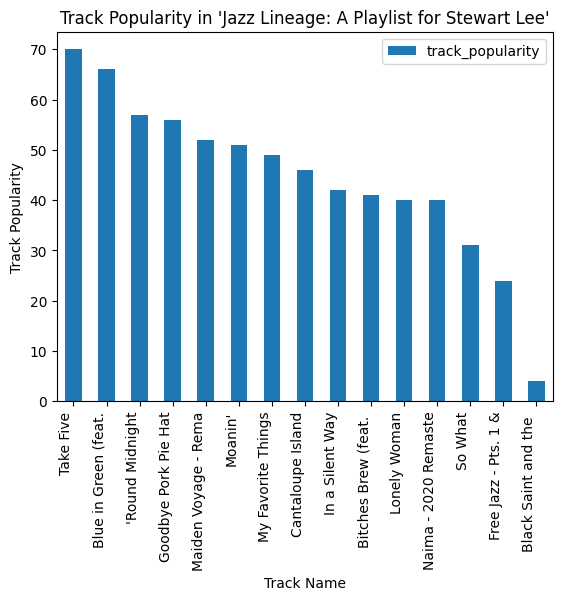

In [4]:
def plotPopularity(name):
    ax = df.sort_values(by='track_popularity',ascending=False).plot(kind='bar', x='track_name', y='track_popularity')
    ax.set_xlabel("Track Name")
    ax.set_ylabel("Track Popularity")
    ax.set_title(f"Track Popularity in '{name}'")
    labels = [name[:20] for name in df.sort_values(by='track_popularity',ascending=False)['track_name']]
    ax.set_xticklabels(labels, rotation=90, ha="right")

plotPopularity(details.get('name'))

### Conducting a Spotify streaming history analysis

See [here](https://github.com/jayeshironside/Spotify-Streaming-history-analysis) for more details on how to analyse your streaming history.  You first need to download your Spotify data locally.  If you are logged in on a browser you can do that by going to [https://www.spotify.com/uk/account/privacy/](https://www.spotify.com/uk/account/privacy/).  Scroll down and you should see the following.  It takes up to 5 days for the link to be emailed to you if you select basic account information.  If you want extended streaming history, that takes 30 days to download.

<img src= "DataCopy.png" width=400\>

For the basic download, you will find it in the download in a file called `StreamingHistory0.json` which covers the last one year.  Let's read it in and see what it reveals:

In [5]:
stream_df = pd.read_json('MyData/StreamingHistory0.json')
print(f'{stream_df.shape[0]} rows with {stream_df.shape[1]} columns: {stream_df.columns.values}')

3179 rows with 4 columns: ['endTime' 'artistName' 'trackName' 'msPlayed']


Let's prepare for further analysis by adding a couple of extra columns:

In [6]:
stream_df['hoursPlayed'] = stream_df['msPlayed']/(1000 * 60 * 60)
stream_df['count'] = 1

In [7]:
stream_df.head(4)

,endTime,artistName,trackName,msPlayed,hoursPlayed,count
0,2022-07-07 23:53,Saint Etienne,Speedwell - The Aloof Mix,11391,0.003164,1
1,2022-07-07 23:54,Saint Etienne,Only Love Can Break Your Heart - Masters at Wo...,66133,0.018370,1
2,2022-07-07 23:54,Chez Damier,I Never Knew Love - Made In Detroit Extended Mix,10773,0.002992,1
3,2022-07-07 23:54,Terrence Parker,Love's Got Me High - Original Vocal Mix,14079,0.003911,1


Let's look at the number of unique artists in the set.  This is a proxy for diversity.  100% means every artist in the set is unique.  A very low percentage indicates you are listening to the same artist.

In [8]:
unique_artists = stream_df['artistName'].nunique() # Count number of unique artist in dataset
total_artists = stream_df['artistName'].count() # Count total artist in dataset
unique_artist_percentage = unique_artists/total_artists*100 # Get the percentage of the unique
print(f'Percentage of unique artists in the total artists is {unique_artist_percentage.round(2)}%')

Percentage of unique artists in the total artists is 28.34%


Top 10 unique artists can be found by doing a `groupby` on `artistName` sorted by `msPlayed`:

In [9]:
N = 20
top_artist_df = stream_df.groupby(['artistName'])[['hoursPlayed']].sum().sort_values(by='hoursPlayed',ascending=False)
top_artist_df.head(N)

,hoursPlayed
artistName,
Talk Talk,5.935104
Burial,5.500569
T. Rex,5.491149
The Orb,5.333511
Aphex Twin,4.178761
Ishmael Ensemble,3.791960
Gerry Rafferty,3.755279
Howard Jones,3.221643
Jamezy,2.811192


Now let's plot the top 30 by `hoursPlayed`:

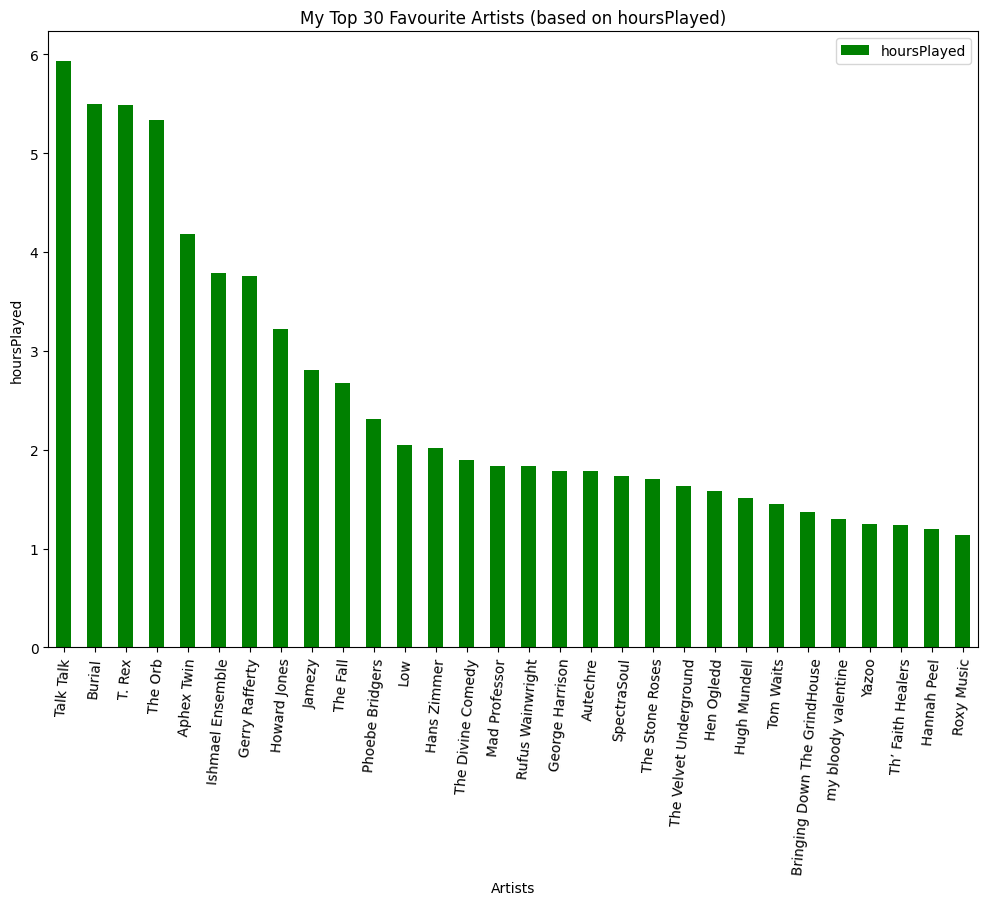

In [10]:
def plotByValue(df, y, what='Artists', N=20):
    ax = df.head(N).plot(kind='bar',y=y,color='green',rot=85,figsize=(12,8))
    ax.set_title(f"My Top {N} Favourite {what} (based on {y})")
    ax.set_xlabel(what)
    ax.set_ylabel(f"{y}")

plotByValue(top_artist_df, 'hoursPlayed', N=30)

And the top 20 by `count` of songs:

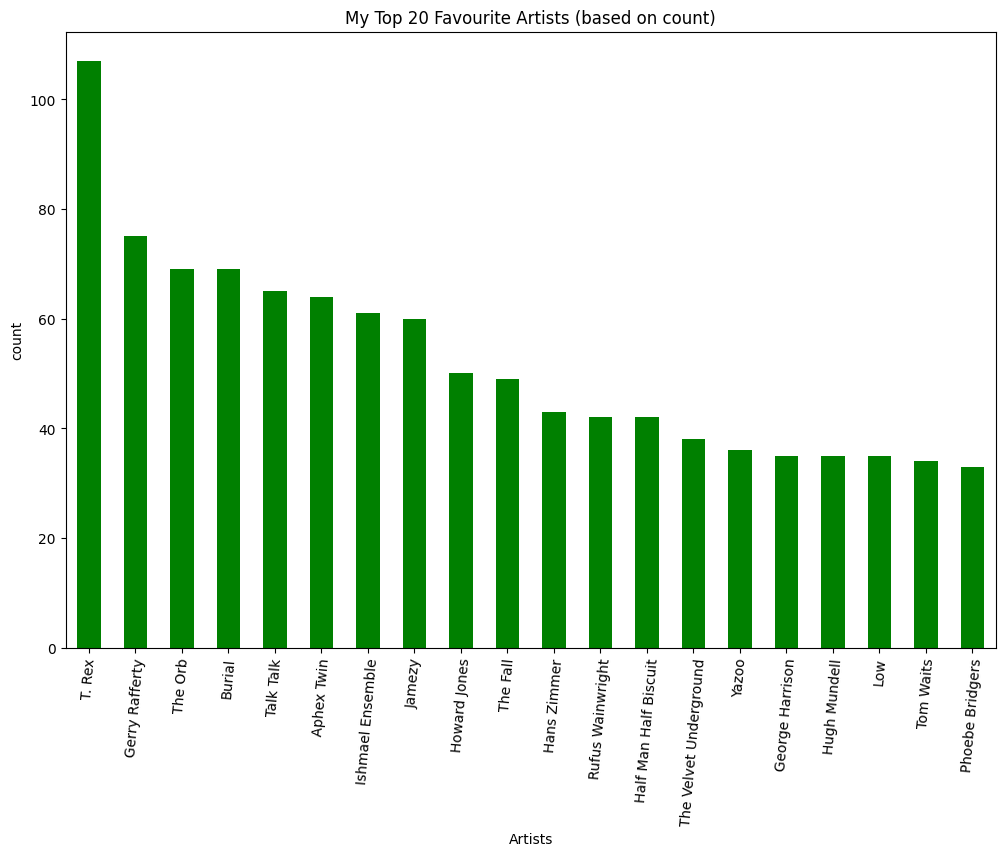

In [11]:
N = 20
top_artist_count_df = stream_df.groupby(['artistName'])['count'].sum().sort_values(ascending=False)
plotByValue(top_artist_count_df, 'count', N=N)

Now let's do the same with tracks instead of artists to understand which tracks were played the most:

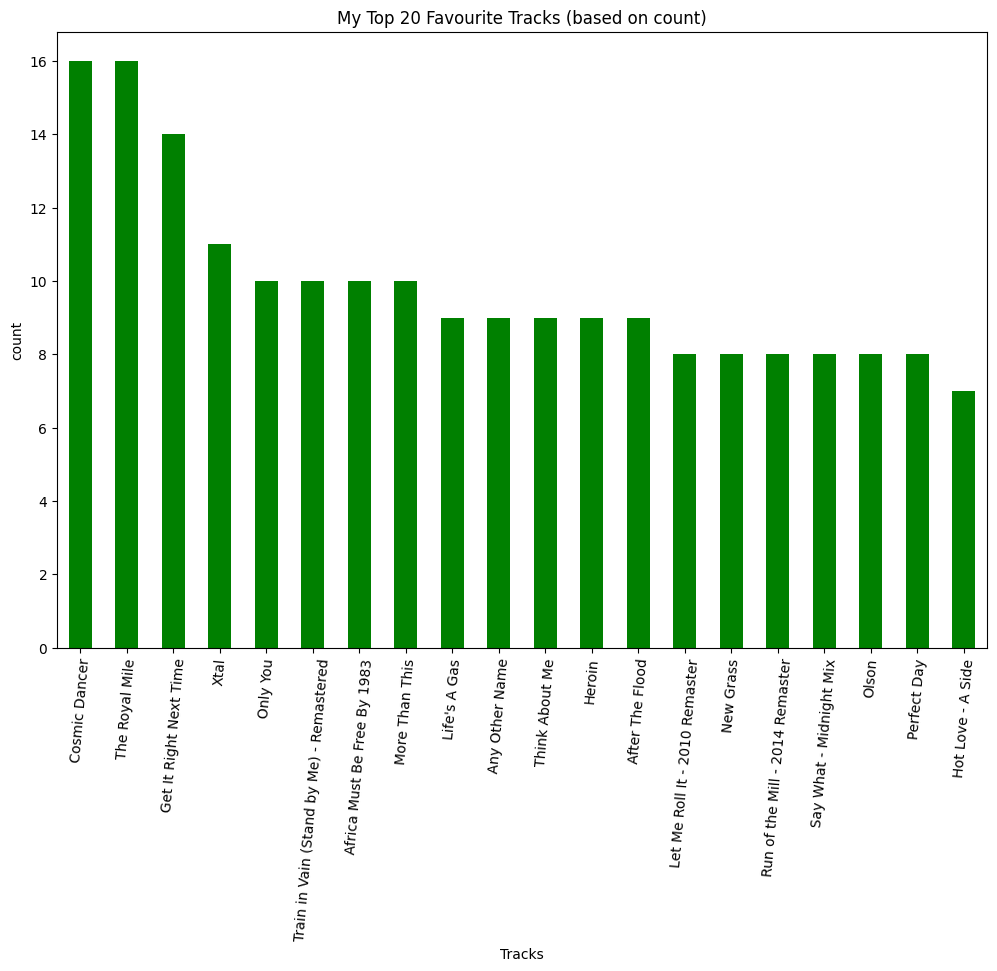

In [12]:
N = 20
top_tracks_df = stream_df.groupby(['trackName'])['count'].sum().sort_values(ascending=False)
plotByValue(top_tracks_df, 'count', what='Tracks', N=N)

Average number of songs played per day given this is a year of streaming data:

In [13]:
(stream_df['trackName'].count()/365).round(2)

8.71

Let's draw a word cloud of favourite artist by count of songs played using `top_artist_count_df` which we already created:

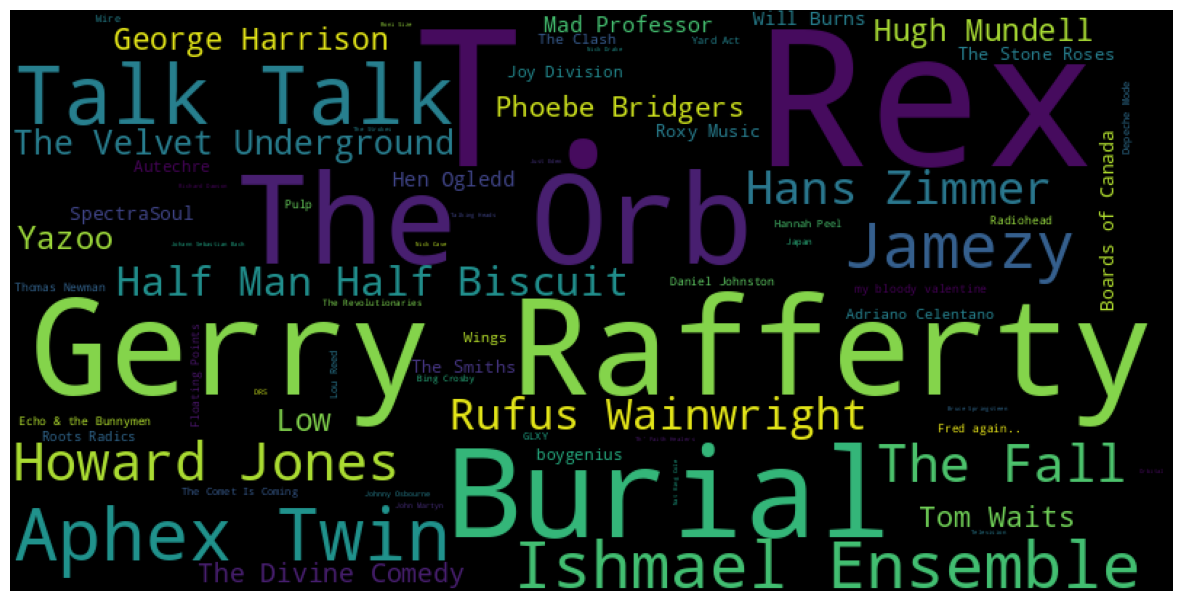

In [14]:
from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt

def plot_cloud(wordcloud):
    fig = plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis('off')

wordcloud = WordCloud(width=800,height=400, 
                      max_words=100,
                      relative_scaling=1,
                      normalize_plurals=False,
                      collocations=False).generate_from_frequencies(top_artist_count_df)
plot_cloud(wordcloud)